# 使用python進行地理資訊分析與圖片呈現

本頁面是以jupyter notebook製成，是為了嘗試可以生成與QGIS分析一樣的效果，但用python code達到自動化的目標，在往後有同一格式之資料表匯入時，我們一樣可以直接執行程式得到我們想要的結果。另外，我也希望這個程式碼可以在線上直接透過binder可以測試與運行。

## 插件匯入

在使用python來處理與分析地理圖資時，我們會用到的插件除了常見的數據分析工具**Pandas**、可以畫圖的**MatPlotLibrary**、可以生成與數學相關資料格式的**NumPy**以外，我們還需要可以讀取地理圖資的**geopandas**、可以生成幾何形狀的**Shapely**來幫我們做到地理圖資的生成與分析。至於**geoplot**則是一個測試用的繪圖工具，但至於我們為甚麼沒有以這個插件做為主要的呈現工具，我在最後面會簡單解釋。

首先，我們先用`import`把這些工具叫到這個notebook裡面。

In [2]:
import geopandas as gpd
import geoplot as gplt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString

叫進來以後，我們就可以用**geopandas**幫助我們讀取我們事先準備好的shapefile。我在這裡使用的，是已經用QGIS用`explode`工具把各線段分開並且有方向角資料的河流圖資，以及預先處理過有方向角的點位圖資。

In [3]:
pre_gdf = gpd.read_file('nanshan_100_TW97_diff.shp')
river = gpd.read_file('ZhuShi_exploded.shp')

gdf = pre_gdf.dropna(subset=['緯度'])

gdf

編號         緯度          經度  橫額      西元  \
0   {2eb298f7-fd47-4e25-b0de-0e1c93a5fb8a}  22.969411  120.202380  海澄  1921.0   
1   {bda21cbb-632a-4540-8378-1805f1652207}  22.969329  120.202314  泉州  1927.0   
2   {bc9a26ea-0fcb-44eb-9fa0-4109384b8c0f}  22.969297  120.202294  台南  1937.0   
3   {4f9a6683-550a-4673-ac35-75dd23500005}  22.968941  120.202245  龍溪  1975.0   
4   {88370ce7-24b8-4d05-b0c5-507239c05a26}  22.969109  120.202375  台南  1939.0   
..                                     ...        ...         ...  ..     ...   
95  {26eaa5bd-cf71-4923-aefb-d185dffd9d6c}  22.965574  120.200858  台南  1938.0   
96  {69bc57d9-73b9-462b-863a-0d2eea1dbdd2}  22.965812  120.200662  錦繡  1962.0   
97  {ea6a9e30-a2bc-46c7-abfa-740ebbee2a91}  22.966032  120.200732  金浦  1962.0   
98  {f431a6e9-0636-4ce1-a096-11b2a4510e12}  22.967167  120.200170  海澄  1921.0   
99  {2452f452-efa8-4793-ab18-5ecf5731df6d}  22.967281  120.200009  龍溪     NaN   

    墓葬方?  墓塚形?  Azimuth  size  Azi_river  azi_diff azi_crit  \
0    單人葬    漢式    165.0     4     83.694    81.306        1   
1   夫妻合葬    漢式    133.0     3     77.630    55.370        0   
2    單人葬    漢式      5.0     3        NaN       NaN       -1   
3   家族合葬  創新形式    145.0     6     92.345    52.655        0   
4    單人葬    漢式    165.0     5     92.787    72.213        1   
..   ...   ...      ...   ...        ...       ...      ...   
95   單人葬    漢式    183.0     2        NaN       NaN       -1   
96  家族合葬    漢式    280.0     9     15.115    84.885        1   
97   單人葬    漢式    270.0    10     15.115    74.885        1   
98   單人葬    漢式     95.0     8    349.401    74.401        1   
99   單人葬    漢式     90.0     9    349.401    79.401        1   

                          geometry  
0   POINT (168213.910 2541118.106)  
1   POINT (168207.114 2541109.065)  
2   POINT (168205.033 2541105.535)  
3   POINT (168199.764 2541066.112)  
4   POINT (168213.226 2541084.624)  
..                             ...  
95  POINT (168055.559 2540693.976)  
96  POINT (168035.593 2540720.479)  
97  POINT (168042.863 2540744.802)  
98  POINT (167985.917 2540870.831)  
99  POINT (167969.528 2540883.566)  

[100 rows x 13 columns]

## 方向角線段投影

python中計算的運作原理與QGIS大致相同，我們一樣需要用先投影出另外一個點以後，把兩個點連在一起形成線段。在達成這個目標之前，我們必須要先處理幾何運算的部分。

### 方位角預處理

我在這裡定義一個功能`cosdir()`，讓他用三角函數的方式來幫我運算方向角在x和y方向的餘弦值，並在計算完以後進行回傳。除此之外，我也在這裡先定義我後面想要投出的長度，而之所以會是0.001，是因為這邊運算的方式是以經緯度為單位，由於經度一度大約等於111公里，0.001度就會是一個接近於100公尺的數字。

In [4]:
def cosdir(azim):
    az = np.radians(azim)
    cosa = np.sin(az)
    cosb = np.cos(az)
    return cosa,cosb

az = gdf['Azimuth']

length = 0.001 #設定長度

完成定義以後，我們就可以開始進行投影。

### 用迴圈進行迭代來生成線段

不如QGIS方便的地方，在於如果我們想要在python中生成線段，必須使用**Shapely**這個插件之中的`Point`和`LineString`來幫我們生成幾何的資料，但因為這兩個功能本身都只能讀取值，而不能直接運算geodataframe的格式，所以我們只能在迴圈鐘用迭代的方式一個一個讀取其中的值，再形成點與線段。

在開始迭代之前，我先開了三個清單，方便在後面的迴圈中可以把運算出來的值用`append`的方式加到清單當中，而真正在後面運算有功能的只有`LineGeometries`這個清單，至於`pointslist`與`endline`都是可以讓我確定運算是否正常、實際算出來的值長怎樣的清單。可以試著在**binder**裡面將`print(pointslist)`或`print(endlines)`取消註解，就可以看到運算的結果清單。如果不需要的話，也可以將任何跟`pointslist`與`endline`有關的程式碼進行註解，以免佔運算空間。

In [5]:
LineGeometries = []
pointslist = []
endlines = []

for index,row in gdf.iterrows():
    cosa, cosb = cosdir(row['Azimuth'])
    pnt_x = row['經度']
    pnt_y = row['緯度']
    point = Point(pnt_x, pnt_y)
    pointslist.append(point)
    endline = Point(pnt_x + (length*cosa), pnt_y+ (length*cosb))
    endlines.append(endline)
    line = LineString([point, endline])
    LineGeometries.append(line)

# print(pointslist)
# print(endlines)

LineGeometries

[<LINESTRING (120.202 22.969, 120.203 22.968)>,
 <LINESTRING (120.202 22.969, 120.203 22.969)>,
 <LINESTRING (120.202 22.969, 120.202 22.97)>,
 <LINESTRING (120.202 22.969, 120.203 22.968)>,
 <LINESTRING (120.202 22.969, 120.203 22.968)>,
 <LINESTRING (120.202 22.969, 120.203 22.969)>,
 <LINESTRING (120.202 22.969, 120.203 22.968)>,
 <LINESTRING (120.202 22.969, 120.203 22.968)>,
 <LINESTRING (120.202 22.969, 120.202 22.968)>,
 <LINESTRING (120.202 22.969, 120.202 22.968)>,
 <LINESTRING (120.202 22.969, 120.203 22.969)>,
 <LINESTRING (120.202 22.969, 120.202 22.968)>,
 <LINESTRING (120.202 22.969, 120.202 22.968)>,
 <LINESTRING (120.202 22.969, 120.202 22.968)>,
 <LINESTRING (120.202 22.969, 120.202 22.968)>,
 <LINESTRING (120.202 22.969, 120.201 22.968)>,
 <LINESTRING (120.202 22.969, 120.202 22.968)>,
 <LINESTRING (120.202 22.969, 120.202 22.968)>,
 <LINESTRING (120.202 22.969, 120.202 22.968)>,
 <LINESTRING (120.202 22.969, 120.202 22.968)>,
 <LINESTRING (120.202 22.969, 120.203 22.

如此一來，我們的線段就都生成完成，並且被放在一個叫做`LineGeometries`的清單內。但這個生成的幾何圖案，其實只是x、y座標平面上的形式。要把他變成有地理意義的，我們必須再次用**geopandas**把他生成一個新的geodataframe，並指定投影系統。由於原本的投影系統是使用經緯度的**WGS84（epsg:4326）**，而配合其他圖資是以**TWD97（epsg:3826）**的格式儲存，我們一開始要先加入`crs='epsg:4326'`的指令指定他的投影系統，再用`to_crs('epsg:3826')`的方式重新投影到TWD97的座標中。

另外，我們也可以將形成的geodataframe輸出成shapefile檔，也可以讓這筆資料後續變得可以使用其他GIS軟體來操作。

In [6]:
line_gdf = gpd.GeoDataFrame(gdf['Azimuth'], geometry=LineGeometries, crs='epsg:4326')
line_plot = line_gdf.to_crs('epsg:3826')

line_gdf.to_file('py_azi.shp')

### 使用matplotlib測試繪圖

有了TWD97系統的三個geodataframe以後，我們就可以試著來畫圖，看看我們的運算結果是否成功，而這裡開始要借助**MatPlotLibrary**來幫我們畫圖。我先用原本的點位資料作為底圖`base`開出一張圖，並以大小等級作為顏色變化的依據。接著，讓河流和我們剛剛產出來的線段投在`base`這個底圖之上（`ax=base`）。為了跟原本QGIS產出來的圖片一樣，我設定了顏色與算段的格式為虛線`dashed`。呈現的圖片在下方程式碼的運算結果中。

<Axes: >

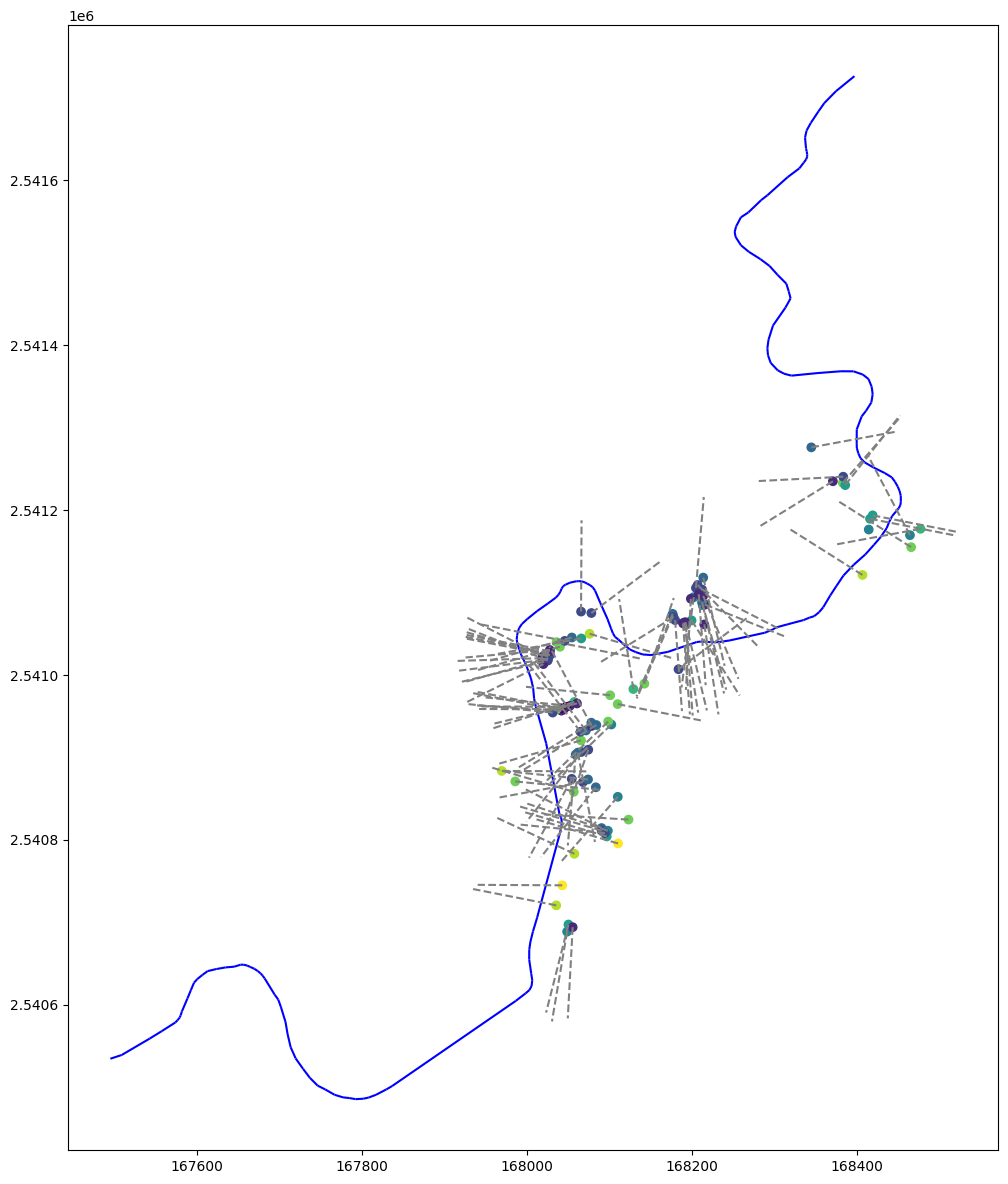

In [7]:
base = gdf.plot(column='size',  figsize=(12,24))
river.plot(color='blue', ax=base)
line_plot.plot(color='gray', linestyle = 'dashed', ax=base)

## 找出交會點與計算交角

交角的計算包含兩個部分：第一個部分是找到兩個圖層的交點，第二個部分是交角的運算。

第一個部分，我們可以很簡單的使用`gpd.overlay`來幫我們找到交點的所有位置。由於線段交會的地方是點，指令會預設輸出的幾何形狀跟原本的幾何形狀要一直，所以要加上`keep_geom_type=False`這個指令。

至於第二個部分，由於交點的新圖層`intsc`原本就會有兩個交角的資訊，我們同樣用迴圈迭代的方式就可以運算交角的結果，並透過`if`函數來幫我們把值運算到0到90度以內。跟算段的運算很類似。我先開了一個叫`Azi_diff`的清單，把運算結果用`append`加到這個清單以後，再把他加回原本的geodataframe作為一個欄位。

In [8]:
# 算交會點嘗試
intsc = gpd.overlay(line_plot, river, how='intersection',keep_geom_type=False)

#這邊都在畫圖
# base = river.plot(figsize=(12,24), color='blue')
# gdf.plot(column='size',  ax=base)
# line_plot.plot(color='gray', linestyle = 'dashed', ax=base)
# intsc.plot(marker='x', color='red', ax=base)

#下面開始算交角

Azi_diff = []

for index, row in intsc.iterrows():
    if abs(row['Azi_river'] - row['Azimuth']) < 180:
        if abs(row['Azi_river'] - row['Azimuth'])<90:
            diff = abs(row['Azi_river'] - row['Azimuth'])
            Azi_diff.append(diff)
        else:
            diff = 180-abs(row['Azi_river'] - row['Azimuth'])
            Azi_diff.append(diff)
    else:
        if 180 < abs(row['Azi_river'] - row['Azimuth']) < 270:
            diff = abs(row['Azi_river'] - row['Azimuth'])-180
            Azi_diff.append(diff)
        else:
            diff = 360 - abs(row['Azi_river'] - row['Azimuth'])
            Azi_diff.append(diff)

intsc.insert(3,'Azi_diff',Azi_diff)

Azi_diff.clear() #清理清單以防下次append重複加入

intsc

Azimuth  id  Azi_river  Azi_diff                        geometry
0     165.0   1     83.694    81.306  POINT (168232.845 2541039.977)
1     133.0   1     77.630    55.370  POINT (168268.339 2541046.734)
2     145.0   1     92.345    52.655  POINT (168216.423 2541040.110)
3     170.0   1     92.345    77.655  POINT (168218.534 2541040.024)
4     165.0   1     92.787    72.213  POINT (168224.092 2541039.788)
..      ...  ..        ...       ...                             ...
82    280.0   1     12.580    87.420  POINT (167989.116 2541052.440)
83    275.0   1    346.789    71.789  POINT (168007.499 2540984.692)
84    293.0   1     15.115    82.115  POINT (168036.014 2540793.049)
85    280.0   1     15.115    84.885  POINT (168017.377 2540724.051)
86    270.0   1     15.115    74.885  POINT (168023.011 2540744.910)

[87 rows x 5 columns]

可以看到運算結果，交角有被完整的計算出來，且都在0到90度以內。在這裡也可以注意，座標的格式是**TWD97**，而不是原本的經緯度座標**WGS84**。
接著，我們可以繼續嘗試繪圖。

### 用matplotlib繪圖

現在每個圖資都準備就緒了，就可以正式的進行繪圖。

為了繪圖方便、不要讓大量的小數點出現在圖上，我一開始先用`round`這個指令把剛剛算出來的交角進位到小數點第三位。
其他的跟前面一樣，但我在這邊加上了`legend=True, categorical=True, cmap='viridis'`這一串指令來設定圖例的顏色與位置。另外，我也使用了`annotate`這個指令來幫我在每一個交角標上它們的值，並且用`plt.savefig()`來幫我儲存輸出圖片，其中`dpi`的設定則是在定圖片的解析度。

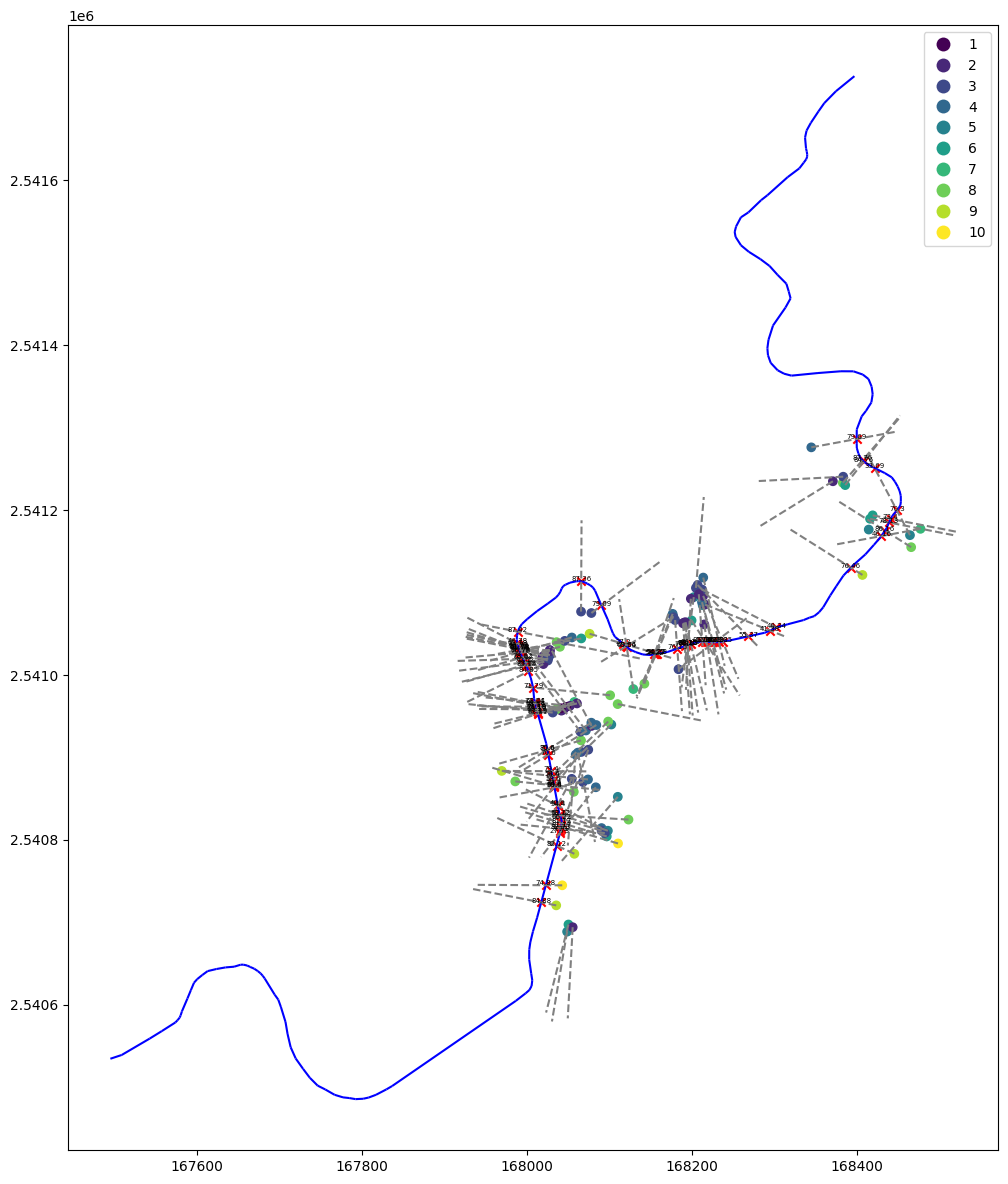

In [9]:
intsc['Azi_diff'] = intsc['Azi_diff'].round(2) #畫圖方便用，不需要可註解

base = gdf.plot(column='size', figsize=(12,24), legend=True, categorical=True, cmap='viridis')
river.plot(color='blue', ax=base)
line_plot.plot(color='gray', linestyle = 'dashed', ax=base)

intsc.plot(marker='x', color='red', ax=base)
intsc.apply(lambda x: base.annotate(text=x['Azi_diff'], xy=x.geometry.centroid.coords[0], ha='center', size='5'), axis=1)

plt.savefig('intersected_test2.png',dpi=300)

若要看到局部的內容，我們則可以使用`base.set_xlim`和`base.set_ylim`來設定圖幅。其他條件維持之下，就可以輸出指定圖幅的範圍。

0     Annotation(168233, 2.54104e+06, '81.31')
1     Annotation(168268, 2.54105e+06, '55.37')
2     Annotation(168216, 2.54104e+06, '52.66')
3     Annotation(168219, 2.54104e+06, '77.66')
4     Annotation(168224, 2.54104e+06, '72.21')
                        ...                   
82    Annotation(167989, 2.54105e+06, '87.42')
83    Annotation(168007, 2.54098e+06, '71.79')
84    Annotation(168036, 2.54079e+06, '82.12')
85    Annotation(168017, 2.54072e+06, '84.88')
86    Annotation(168023, 2.54074e+06, '74.88')
Length: 87, dtype: object

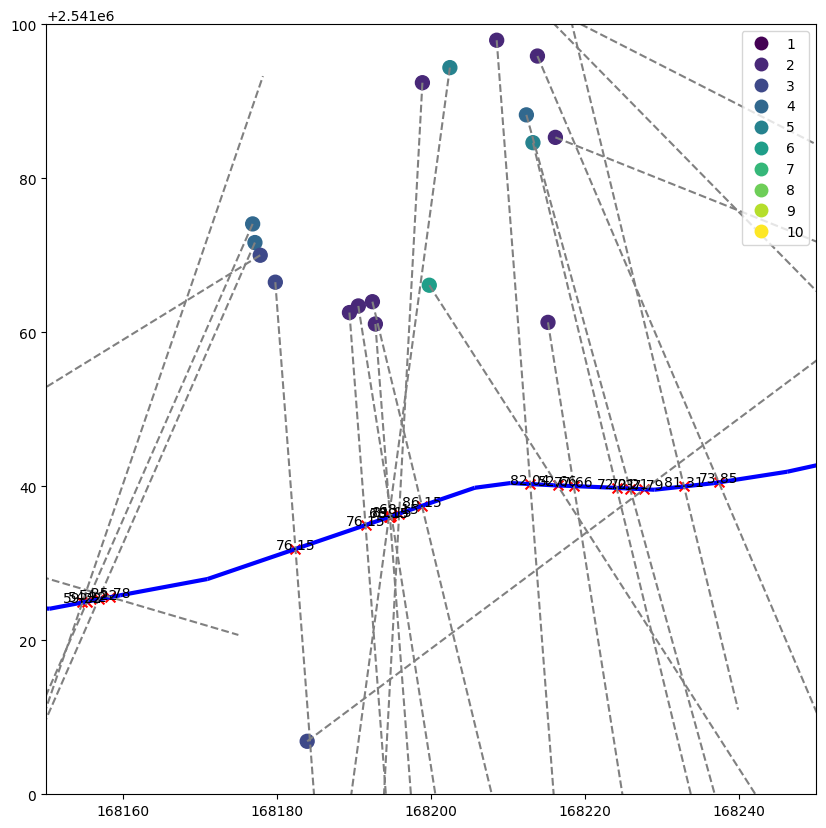

In [10]:
#測試設定圖幅

base = gdf.plot(column='size', markersize=100, figsize=(10,10), legend=True, categorical=True, cmap='viridis')


xlim = ([168150, 168250])
ylim = ([2.5410E6, 2.5411E6])

base.set_xlim(xlim)
base.set_ylim(ylim)


river.plot(color='blue', linewidth=3, ax=base)
line_plot.plot(color='gray', linestyle = 'dashed', ax=base)

intsc.plot(marker='x', color='red', ax=base, markersize=50)
intsc.apply(lambda x: base.annotate(text=x['Azi_diff'], xy=x.geometry.centroid.coords[0], ha='center', size='10'), axis=1)

我們一樣可以用迭代的方式來指定70度的標準，並新增一個新的欄位。然後我們在繪圖時就可以區分有通過標準的顏色與沒有通過的。

0     Annotation(168233, 2.54104e+06, '81.31')
1     Annotation(168268, 2.54105e+06, '55.37')
2     Annotation(168216, 2.54104e+06, '52.66')
3     Annotation(168219, 2.54104e+06, '77.66')
4     Annotation(168224, 2.54104e+06, '72.21')
                        ...                   
82    Annotation(167989, 2.54105e+06, '87.42')
83    Annotation(168007, 2.54098e+06, '71.79')
84    Annotation(168036, 2.54079e+06, '82.12')
85    Annotation(168017, 2.54072e+06, '84.88')
86    Annotation(168023, 2.54074e+06, '74.88')
Length: 87, dtype: object

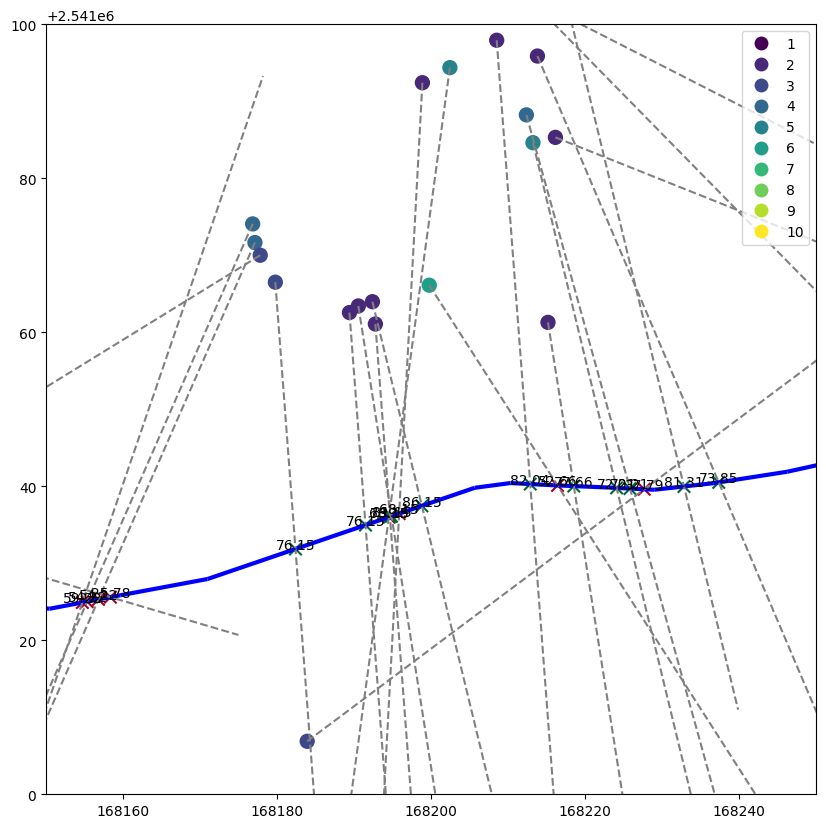

In [11]:
#criteria設定

Azi_crit = []

for index, row in intsc.iterrows():
    if row['Azi_diff'] > 70:
        crit = 1
        Azi_crit.append(crit)
    else:
        crit = 0
        Azi_crit.append(crit)

intsc['Azi_crit'] = Azi_crit

base = gdf.plot(column='size', markersize=100, figsize=(10,10), legend=True, categorical=True, cmap='viridis')


xlim = ([168150, 168250])
ylim = ([2.5410E6, 2.5411E6])

base.set_xlim(xlim)
base.set_ylim(ylim)


river.plot(color='blue', linewidth=3, ax=base)
line_plot.plot(color='gray', linestyle = 'dashed', ax=base)

intsc.plot(column='Azi_crit', marker='x', ax=base, markersize=80, cmap='RdYlGn')
intsc.apply(lambda x: base.annotate(text=x['Azi_diff'], xy=x.geometry.centroid.coords[0], ha='center', size='10'), axis=1)

## Folium：互動式地圖的生成

在geopandas中，其內建**Folium**的`explore`這個工具，可以把我們所設定的檔案用GeoJson的形式投射到OpenStreetMap中，並形成互動式地圖。這樣一來，我們也可以看到每一筆資料的詳細資訊。

In [14]:
#explore測試

m = gdf.explore(column="size", marker_kwds=dict(radius=5, fill=True))

river.explore(m=m)
line_plot.explore(m=m, color="gray")
intsc.explore(m=m, color="red", column="Azi_crit", cmap='RdYlGn')

m.save("nanshan.html")

m

## 一些討論

### Appendix1：geoplot以及為甚麼不用？

在生成主題地圖的工具中，有另一個工具叫**geoplot**。**geoplot**相對於geopandas和matplotlibrary其實在表現上強大許多，例如在下面的範例中，它可以依據欄位的數值大小來控制點位面積的大小。可惜的是，**geoplot**只能呈現點與多邊形的資料，而在這個分析中用到的資料絕大多數是線段的圖層，因此無法完整傳達我們想要的結果。

c:\Users\terry\AppData\Local\Programs\python\Lib\site-packages\geoplot\geoplot.py:56: UserWarning: The data being passed to "hue" includes null values. You probably want to remove these before plotting this data with geoplot.
  warnings.warn(
c:\Users\terry\AppData\Local\Programs\python\Lib\site-packages\geoplot\geoplot.py:248: UserWarning: Please specify "legend_var" explicitly when both "hue" and "scale" are specified. Defaulting to "legend_var='hue'".
  warnings.warn(


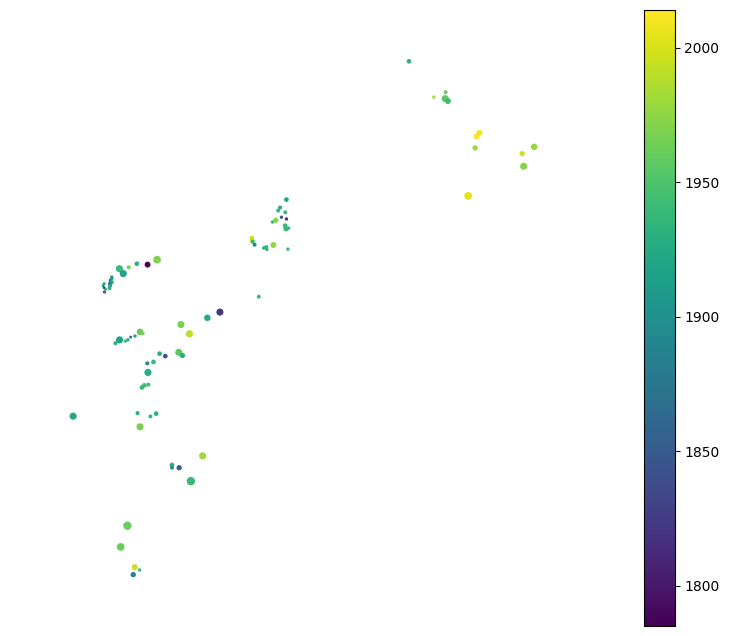

In [13]:
#geoplot測試

gdf_4326 = gdf.to_crs('epsg:4326')
base2 = gplt.pointplot(gdf_4326, figsize=(16,8), scale='size', legend='size', hue='西元')

### Appendix2：為甚麼不加入航測影像？

在geopandas中，我們其實可以用另一個插件**rasterio**來幫我們插入網格類型的航照影像，且我們也真的有航照影像可以使用。但因為航照影像檔案太大，載入與運算時需要大量的時間，因此就沒有在這個計畫中呈現。